# Wikipedia Learning Suggestion

Lot of times when we are learning about stuff through wikipedia, we have to click on multiple "sub-links" and read about them first. Soon enough, we are drowned in the overwhelming number of tabs of wikipedia pages. 

Here, I try to process the user search query and generate an ordered list of topics which the user can read sequentially to get a comprehensive and clear idea of what he/she wanted to read in the first place.

With a wikipedia "web" of pages, with all the outlinks and inlinks, PageRank algorithm can find out "importance" score of the pages. And alongwith the "depth" of the page, i.e. how far is the page from the orignal page, these result pages can be ranked and retrieved to the user. 

We can index wikipedia pages, but I thought of doing it online, as in live crawl, in case of unavailability of indexed pages. This posses major problems, not only computational time, but because my web-graph would be incomplete, especially shallower pages would not have the inlinks it ideally should have.

In [41]:
import os
import re
import requests
from pattern import web
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sets import Set
import time
import pickle
import networkx as nx

### Getting a page
Wth is it taking 16 seconds to get the contents of the page? Have to explore that.

In [8]:
t0 = time.time()
r = requests.get("http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation")
t1 = time.time()
print t1 - t0

16.1499390602


### Initializing the graph
Initializing the dataframe, with a dummy search "Latent Dirichlet Allocation"

In [52]:
df = pd.DataFrame(columns = ['_name','url','outlink','inlink'])
url_dict = {}
i = 0
forest = set()
df.loc[i] = ["Latent Dirichlet allocation", "/wiki/Latent_Dirichlet_allocation",
             None, None]
url_dict["/wiki/Latent_Dirichlet_allocation"] = i
df.head()

,_name,url,outlink,inlink
0,Latent Dirichlet allocation,/wiki/Latent_Dirichlet_allocation,None,None


## Depth First Search Iteration
I am iterating over the pages, in a depth first search manner. This does not seem to be an efficient way to explore pages. I need to try out uniform cost search, with score as function of (number of inlinks,depth)

TODO: Uniform Cost search

In [47]:
# df = dataframe to store data of each node
# adjlist - adjancency list storing edges between node ids
# node_id - parent node id
# url_dict - to check if already traversed a node
# K - number of children
def get_K_children(K, df, parent_id, url_dict):
    time.sleep(1)
    r = requests.get("http://en.wikipedia.org" + df.loc[parent_id].url)
    bs = BeautifulSoup(r.text)
    para = bs.find_all('p')
    atags = [(a['title'],a['href']) for p in para for a in p.find_all('a') if a.has_attr('title')]
    i = df.shape[0] # index iterator for df
    df.loc[parent_id].outlink = np.array([],dtype='int')
    for (title,href) in atags:
        if (K == 0):
            break
        if (url_dict.has_key(href)):
            url_id = url_dict[href]
            df.loc[parent_id].outlink = np.append(df.loc[parent_id].outlink,
                                                  url_id)
            df.loc[url_id].inlink = np.append(df.loc[url_id].inlink,
                                              parent_id)
            
        else:
            df.loc[i] = [title, href,None, np.array([parent_id],dtype='int')]
            df.loc[parent_id].outlink = np.append(df.loc[parent_id].outlink, i)
            url_dict[href] = i
            i += 1
        K -= 1
    
# depth - depth to which graph needs to be extracted
# parent_id - parent id to start graph with
# adjlist - adjancency list storing edges between node ids
# node_id - parent node id
# url_dict - to check if already traversed a node
# forest - to check if the node's children are already extracted
# K - number of children to be explored
def create_graph(K, df, depth, parent_id, url_dict, forest):
    parent_url = df.loc[parent_id].url
    if (depth > 0 and (parent_url not in forest)):
        forest.add(parent_url)
        get_K_children(K, df, parent_id, url_dict)
        adjlist = df.loc[parent_id].outlink
        for node_id in adjlist:
            create_graph(K, df, depth - 1, node_id, url_dict, forest)

## The exponential crawl
I think the time complexity of the crawl,though I knew, I guess I had not fully realized. That is why my first try was dfs with branching factor as 15 and depth 5. I was not thinking I guess. I had to interrupt it.

In [ ]:
K = 15
depth = 5
create_graph(K, df, depth, 0, url_dict, forest)
# interupted

In [50]:
df

,_name,url,outlink,inlink
0,Latent Dirichlet allocation,/wiki/Latent_Dirichlet_allocation,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 10, 13...",None
1,Natural language processing,/wiki/Natural_language_processing,"[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...",[0]
2,Generative model,/wiki/Generative_model,None,[0]
3,Latent variable,/wiki/Latent_variable,None,[0]
4,Topic model,/wiki/Topic_model,None,[0]
5,Graphical models,/wiki/Graphical_models,None,[0]
6,David Blei,/wiki/David_Blei,None,[0]
7,Andrew Ng,/wiki/Andrew_Ng,None,[0]
8,Michael I. Jordan,/wiki/Michael_I._Jordan,None,[0]
9,Mixture model,/wiki/Mixture_model,None,[0]


## The Problem
If you want to read about LDA, you might want to read about nlp, PLSA, LSA, topical models etc. But the result below is quite disappointing. First, you don't see PLSA because I reduced the branching factor. Secondly, with relevant topics like, latent variable, topic model, graphical models, the number of links are, now-obvious, very few, because they are very shallow in the tree. 

In [53]:
K = 5
depth = 4
create_graph(K, df, depth, 0, url_dict, forest)

In [54]:
df

,_name,url,outlink,inlink
0,Latent Dirichlet allocation,/wiki/Latent_Dirichlet_allocation,"[1, 2, 3, 4, 5]",None
1,Natural language processing,/wiki/Natural_language_processing,"[6, 7, 8, 9, 10]","[0, 4, 210]"
2,Generative model,/wiki/Generative_model,"[117, 118, 3, 119, 120]",[0]
3,Latent variable,/wiki/Latent_variable,"[118, 157, 158, 159, 160]","[0, 2, 159]"
4,Topic model,/wiki/Topic_model,"[120, 1, 142, 198, 199]",[0]
5,Graphical models,/wiki/Graphical_models,"[226, 227, 228, 138, 124]",[0]
6,Computer science,/wiki/Computer_science,"[11, 12, 13, 14, 15]","[1, 14, 185, 232]"
7,Artificial intelligence,/wiki/Artificial_intelligence,"[38, 39, 40, 41, 42]","[1, 40, 41]"
8,Linguistics,/wiki/Linguistics,"[11, 65, 66, 67, 68]","[1, 65, 67, 68, 68, 10]"
9,Computer,/wiki/Computer,"[79, 80, 81, 82, 83]","[1, 79, 81, 82]"


In [43]:
data = {'url_dict':url_dict, 'forest': forest, 'df':df}
pickle.dump(data,open('wikipedia.p','wb'))

## Visualization

In [60]:
graph = nx.Graph()
for name in df._name:
    graph.add_node(name)

for i in range(df.shape[0]):
    node1 = i
    elist = df.loc[i].outlink
    if elist is not None:
        for node2 in elist:
            graph.add_edge(df.loc[int(node1)]._name,
                           df.loc[int(node2)]._name)



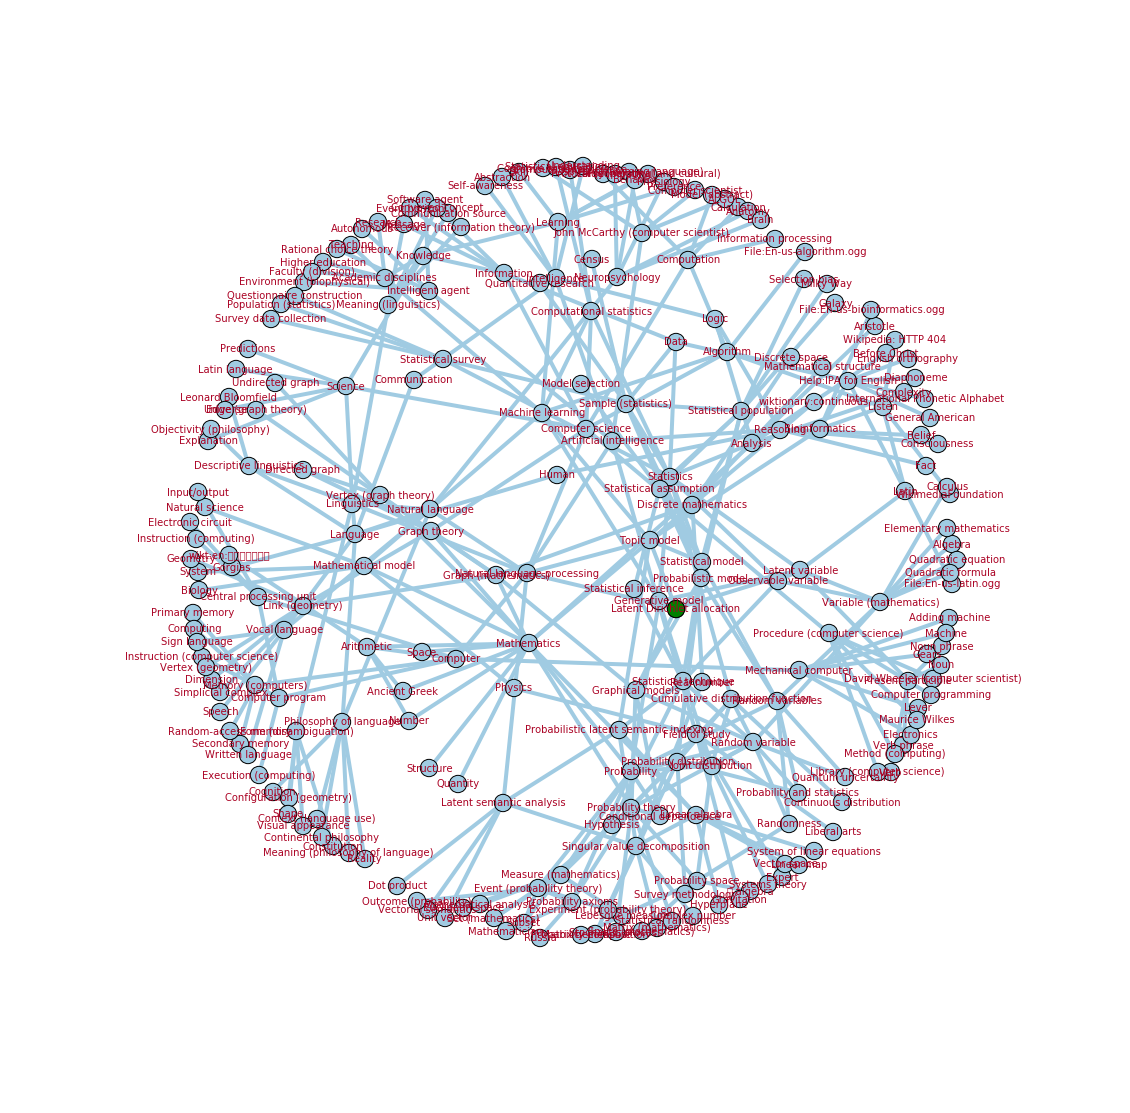

In [64]:
pos=nx.spring_layout(graph)
colors=range(graph.size())
plt.figure(figsize=(15,15))
nx.draw(graph,pos,node_color='#A0CBE2',edge_color="#A0CBE2",width=4)
nx.draw_networkx_nodes(graph,pos,nodelist=["Latent Dirichlet allocation"],node_size=300,node_color='g')
nx.draw_networkx_labels(graph,pos,font_size=10,font_color='#AA0022')
plt.savefig("wiki_graph.png") # save as png
plt.show() # display